# Import statements

In [1]:
# Operating System
import os

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

import sklearn

from sklearn.model_selection import train_test_split

from sklearn.pipeline import  Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin, BaseEstimator

import category_encoders as ce
from sklearn.preprocessing import KBinsDiscretizer, Binarizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix


#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import binom_test

# Strings
import re

# Load original data

In [2]:
file_path = os.path.join('data', 'train.csv')

# Option for reading a sample of the file
# sample 20% of the rows
p = 1

random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change
try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0, 
                             #nrows = 10000, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    # Drop observations correspoding to stops that didn't lead to a search
    df = df_original[df_original.VehicleSearchedIndicator==True].reset_index(drop=True).drop(columns='VehicleSearchedIndicator')


# Custom classes for pipeline

In [3]:
# Custom transformer to implement sentence cleaning
class TextCleanerTransformer(TransformerMixin):
    def __init__(self, 
                 regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")], 
                 lower=True, 
                 remove_punct=True):
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        #X = list(map(self._clean_sentence, X.values))
        X_copy = X.copy()
        X_copy = X_copy.applymap(self._clean_sentence)
        return X_copy
    
    def _clean_sentence(self, sentence):
        
        # Make sure it is a string!
        sentence = str(sentence)
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0], regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()
        
        # Trim
        sentence = sentence.strip()
        
        return sentence
    
    def fit(self, *_):
        return self

In [4]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[self.key]

    
class BoolSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[self.key]

# Train-Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='ContrabandIndicator'), 
                                                    df['ContrabandIndicator'], 
                                                    test_size=0.6, 
                                                    random_state=42)

# Pipeline workflow

In [6]:
# text_pipe = Pipeline([
#                 ('selector', TextSelector(['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])),
#                 ('cleaner', TextCleanerTransformer()),
#                 ('ordinalencoder', ce.ordinal.OrdinalEncoder())
#             ])

text_pipe = Pipeline([
                ('selector', TextSelector(['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])),
                ('ordinalencoder', ce.ordinal.OrdinalEncoder())
            ])

# numerical_pipe =  Pipeline([
#                 ('selector', NumberSelector(['SubjectAge'])),
#                 ('binarizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'))
#             ])

numerical_pipe =  Pipeline([
                ('selector', NumberSelector(['SubjectAge'])),
                ('binarizer', Binarizer(threshold=27))
            ])


bool_pipe =  Pipeline([
                ('selector', BoolSelector(['ResidentIndicator']))                
            ])

# Feature Union allow use to use multiple distinct features in our classifier
feats = FeatureUnion([('text', text_pipe), 
                      ('numerical', numerical_pipe)])

#feats = FeatureUnion([('text', text_pipe)])

# feats = FeatureUnion([('text', text_pipe), 
#                       ('numerical', numerical_pipe),
#                       ('bool', bool_pipe)])

pipe_clf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [7]:
pipe_clf.fit(X_train, y_train)

decision_thr= 0.5

y_prob_pipe = pipe_clf.predict_proba(X_test)[:,1]
y_pred_pipe = y_prob_pipe > decision_thr

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [8]:
y_true = y_test
y_prob = y_prob_pipe
y_pred = y_pred_pipe

# Training results

In [9]:
y_prob_train = pipe_clf.predict_proba(X_train)[:,1]
y_pred_train = y_prob_train > decision_thr

In [10]:
precision_score(y_train, y_pred_train)

0.7152889707575408

In [11]:
recall_score(y_train, y_pred_train)

0.6129636937647988

In [12]:
accuracy_score(y_train, y_pred_train)

0.7916408769586605

# Metrics

In [13]:
precision = precision_score(y_test, y_pred)
precision

0.5998483699772555

In [14]:
recall = recall_score(y_test, y_pred)
recall

0.514367442465219

In [15]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7231464187985928

In [16]:
cf = confusion_matrix(y_test, y_pred)
TN = cf[0][0]
TP = cf[1][1]
FN = cf[1][0]
FP = cf[0][1]

Sanity checks:

In [17]:
precision == TP/(TP+FP) 

True

In [18]:
recall == TP/(TP+FN)

True

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.83      0.80     30664
        True       0.60      0.51      0.55     15382

   micro avg       0.72      0.72      0.72     46046
   macro avg       0.69      0.67      0.68     46046
weighted avg       0.71      0.72      0.72     46046



In [ ]:
y_pred.sum()/y_pred.shape[0]

0.2864526777570256

In [ ]:
y_true.sum()

15382

# Curves

In [ ]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
AUROC = roc_auc_score(y_test, y_prob)*100

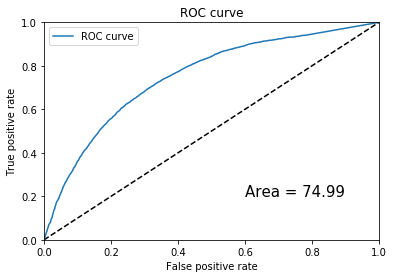

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC,2)), dict(size=15))

plt.legend(loc='best')

plt.savefig(os.path.join('plots', 'ROC_curve.png'))
plt.show()

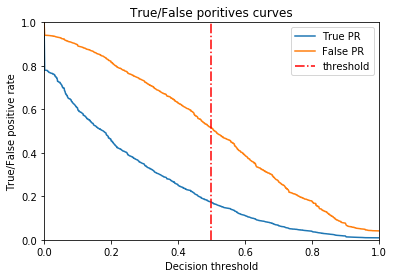

In [ ]:
plt.figure(2)
plt.plot(thresholds_roc, fpr , label='True PR')
plt.plot(thresholds_roc, tpr, label='False PR')

plt.axvline(x=decision_thr, color='r', linestyle='-.', label='threshold')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
plt.title('True/False poritives curves')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')

plt.savefig(os.path.join('plots', 'TP_FP_curve.png'))
plt.show()

In [ ]:
precision_vec, recall_vec, thresholds_pr = precision_recall_curve(y_test, y_prob)

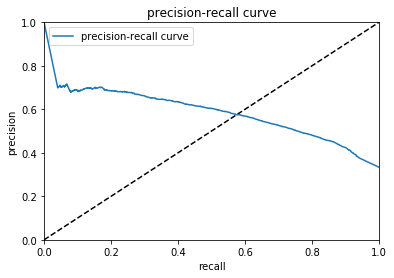

In [ ]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_vec, precision_vec, label='precision-recall curve')

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

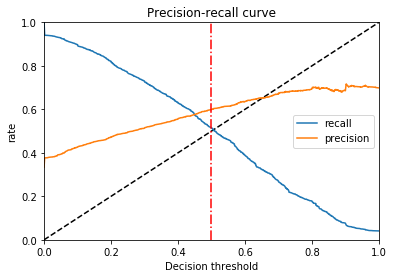

In [ ]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(thresholds_pr, recall_vec[:-1] , label='recall')
plt.plot(thresholds_pr, precision_vec[:-1], label='precision')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('rate')
plt.title('Precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

# Hyperparameter Tuning - Grid Search

In [ ]:
# grid_search_parameter_space_1 = {'max_depth': range(1, 10),
#                    'max_features': range(1, len(independent_variables))
#                   }

In [ ]:
grid_search_parameter_space = {'max_depth': range(1, 20),
                               'min_samples_leaf': range(1, 50)}

In [ ]:
estimator = RandomForestClassifier(random_state = 42)

In [ ]:
grid_search = GridSearchCV(
                estimator,
                grid_search_parameter_space,
                cv=5,
                scoring="recall_weighted",
                return_train_score=True
                )

In [ ]:
%%timeit -n 1 -r 1

grid_search.fit(pipe_clf.steps[0][1].transform(X_train), y_train)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

In [ ]:
#grid_search.cv_results_

In [ ]:
grid_search.best_score_ 

In [ ]:
grid_search.best_estimator_

In [ ]:
sorted(grid_search.cv_results_.keys())

In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
df_results = y_test.to_frame(name='y_true')
df_results['y_pred'] = y_pred
df_results['y_prob'] = y_prob
df_results.head()

In [ ]:
n_trues = df_results[df_results.y_true==True].shape[0]
n_falses = df_results[df_results.y_true==False].shape[0]

plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, weights=np.ones(n_trues)/n_trues*100, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, weights=np.ones(n_falses)/n_falses*100, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("% of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

In [ ]:
plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("Nº of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

In [ ]:
df_results[df_results.y_true==True].y_prob.hist(bins=20, figsize=(8,4), histtype='step',label='positive class', density=True, cumulative=True)
df_results[df_results.y_true==False].y_prob.hist(bins=20, figsize=(8,4), histtype='step', label='negative class', density=True, cumulative=True)

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("Density")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

In [ ]:
df_results.set_index('y_prob').y_true

### Predict all `True`

In [ ]:
y_pred_true = np.ones(y_test.shape).astype(bool)

In [ ]:
precision_score(y_test, y_pred_true)

In [ ]:
recall_score(y_test, y_pred_true)

In [ ]:
accuracy_score(y_test, y_pred_true)

### Predict all `False`

In [ ]:
y_pred_false = np.zeros(y_test.shape).astype(bool)

In [ ]:
precision_score(y_test, y_pred_false)

In [ ]:
recall_score(y_test, y_pred_false)

In [ ]:
accuracy_score(y_test, y_pred_false)

### Predict randomly with positive\negative ratio `r`

In [ ]:
np.random.seed(425)
ratio = 0.90

In [ ]:
# y_pred_rand = np.random.randint(2, size=y_test.shape).astype(bool)
y_pred_rand = np.random.binomial(n=1, p=ratio, size=y_test.shape).astype(bool)

In [ ]:
y_pred_rand.sum()/y_pred_rand.shape[0]

In [ ]:
y_pred_rand.shape

In [ ]:
precision_score(y_test, y_pred_rand)

In [ ]:
recall_score(y_test, y_pred_rand)

In [ ]:
accuracy_score(y_test, y_pred_rand)

# Metrics among protected classes

In [ ]:
df_test_classes = pd.DataFrame({X_test.SubjectRaceCode.name: X_test.SubjectRaceCode, 
                                X_test.SubjectEthnicityCode.name: X_test.SubjectEthnicityCode, 
                                X_test.SubjectSexCode.name: X_test.SubjectSexCode, 
                                'y_true': y_true, 
                                'y_pred': y_pred})

In [ ]:
#sanity check
df_test_classes.shape[0] == X_test.shape[0]

In [ ]:
test_race_results = df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
test_ethnic_results = df_test_classes.groupby(['SubjectEthnicityCode','y_true', 'y_pred']).SubjectEthnicityCode.count()
test_sex_results = df_test_classes.groupby(['SubjectSexCode','y_true', 'y_pred']).SubjectSexCode.count()

Sanity checks:

In [ ]:
test_race_results[:,True,:].sum() == test_ethnic_results[:,True,:].sum() == test_sex_results[:,True,:].sum() == y_true.sum()

In [ ]:
test_race_results[:,:,True].sum() == test_ethnic_results[:,:,True].sum() == test_sex_results[:,:,True].sum() == y_pred.sum()

In [ ]:
df_test_classes.head(10)

### Precision overall

In [ ]:
precision_score(y_true, y_pred)

### Precision among races

In [ ]:
# Sanity check
df_test_classes[df_test_classes.y_pred==True].y_true.mean()

In [ ]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean()

In [ ]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

In [ ]:
(df_test_classes[df_test_classes.y_pred==True].groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

When the classifier predicts positive, it is more sure about the prediction for Whites than for Blacks.

In [ ]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectEthnicityCode').y_true.mean()

In [ ]:
df_test_classes[df_test_classes.y_pred==True].groupby('SubjectSexCode').y_true.mean()

### Recall overall

In [ ]:
recall_score(y_true, y_pred)

In [ ]:
# Sanity check
df_test_classes[df_test_classes.y_true==True].y_pred.mean()

In [ ]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectRaceCode').y_pred.mean()

In [ ]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectEthnicityCode').y_pred.mean()

In [ ]:
df_test_classes[df_test_classes.y_true==True].groupby('SubjectSexCode').y_pred.mean()

In [ ]:
df_test_classes.groupby('SubjectRaceCode')[['y_true', 'y_pred']]

In [ ]:
df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred'])[['y_true', 'y_pred']]

In [ ]:
test_race_results

In [ ]:
test_race_results.loc[:,:,True]

### Precision by class

In [ ]:
test_race_results = df_test_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
test_race_results

In [ ]:
test_race_results.loc[:,False,:]

In [ ]:
# sanity check
df_test_race.y_true.sum() == y_test.sum() and df_test_race.y_pred.sum() == y_pred.sum()

In [ ]:
df_test_race.y_true.sum()

In [ ]:
y_test.sum()

In [ ]:
recall = recall_score(y_test, y_pred)
recall

In [ ]:
df_test_classes = pd.DataFrame({X_test.SubjectRaceCode.name: X_test.SubjectRaceCode, 
                                X_test.SubjectEthnicityCode.name: X_test.SubjectEthnicityCode, 
                                X_test.SubjectSexCode.name: X_test.SubjectSexCode, 
                                'y_true': y_test ,
                                'y_pred': y_pred})
df_test_classes

In [ ]:
5278/(5278+7912)

In [ ]:
confusion_matrix(y_test, y_pred)